# Classification
- Frozen encoder layers with fully convolutional layer
- Re-training the model with the learned weights from the autoencoder
- Randomly initialized model


In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [2]:
# Test connection and path to images
!ls "/gdrive/My Drive/computer-vision-project/dataset_resampled"


images	labels	segmentation


In [3]:
!python "/gdrive/My Drive/computer-vision-project/utils.py"

Using TensorFlow backend.


In [4]:
!pip install livelossplot

In [5]:
import keras
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D,Flatten,Dense,Dropout
from keras.models import Model
from keras.optimizers import RMSprop
from keras.initializers import RandomNormal
import numpy as np
from skimage.transform import resize
from matplotlib import pyplot as plt
from livelossplot import PlotLossesKeras

Using TensorFlow backend.


In [0]:
exec(open('/gdrive/My Drive/computer-vision-project/utils.py').read())

In [0]:
PATH_TO_DATASET = "/gdrive/My Drive/computer-vision-project/dataset_resampled/"
PATH_TO_MODELS = "/gdrive/My Drive/computer-vision-project/models/"

In [0]:
x_train = read_train_images()
x_val = read_validation_images()
x_test = read_test_images()

In [0]:
y_train = read_train_labels()
y_val = read_validation_labels()
y_test = read_test_labels()

In [10]:
print("Training set (images) shape: {shape}".format(shape=x_train.shape))
print("Validation set (images) shape: {shape}".format(shape=x_val.shape))
print("Test set (images) shape: {shape}".format(shape=x_test.shape))

Training set (images) shape: (467, 128, 128, 3)
Validation set (images) shape: (386, 128, 128, 3)
Test set (images) shape: (97, 128, 128, 3)


In [11]:
print("Training set (labels) shape: {shape}".format(shape=y_train.shape))
print("Validation set (labels) shape: {shape}".format(shape=y_val.shape))
print("Test set (labels) shape: {shape}".format(shape=y_test.shape))

Training set (labels) shape: (467, 2)
Validation set (labels) shape: (386, 2)
Test set (labels) shape: (97, 2)


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[0 1]')

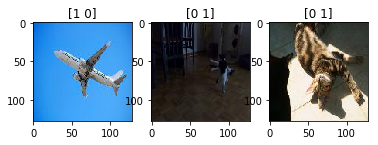

In [12]:
# Display the first image from training data
i=0
plt.subplot(131)
plt.imshow(x_train[i], cmap='gray')
plt.title(y_train[i])

# Display the first image from validation data
plt.subplot(132)
plt.imshow(x_val[i], cmap='gray')
plt.title(y_val[i])

# Display the first image from test data
plt.subplot(133)
plt.imshow(x_test[i], cmap='gray')
plt.title(y_test[i])

Definition of hyperparameters.

In [0]:
batch_size = 32
epochs = 50
inChannel = x_train.shape[3]
x, y = x_train.shape[1], x_train.shape[2]
input_img = Input(shape = (x, y, inChannel))
num_classes = 2

In [14]:
# OPTIMIZER=keras.optimizers.Adam()
OPTIMIZER=keras.optimizers.RMSprop()
LOSS=keras.losses.binary_crossentropy

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
def fully_connected(encoder):
    drop1 = Dropout(rate=0.2)(encoder)
    flat = Flatten()(drop1)
    #den = Dense(128, activation='relu')(flat)
    out = Dense(num_classes, activation='softmax')(flat)
    return out

Read the previously trained autoencoder.

In [16]:
autoencoder = read_model('autoencoder_32_32_64')


Loaded model from disk


In [17]:
autoencoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 256)     7168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       295040    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       73856     
__________

In [0]:
code_layer = autoencoder.get_layer('conv2d_3').output
encoder = Model(inputs=autoencoder.input, outputs=code_layer)


In [19]:
num_encoder_layers = len(encoder.layers)
print('Number of layers in the encoder: ' + str(num_encoder_layers))

Number of layers in the encoder: 6


In [0]:
# Make the encoder part - trainable false
# The encoder part is already trained, so no need to train it
# Only train the Fully Connected part
for layer in encoder.layers:
    layer.trainable = False

In [21]:
full_model = Model(encoder.input, fully_connected(code_layer))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [22]:
autoencoder.get_weights()[0][1]

array([[[-0.00688002,  0.05749084, -0.04860098, ...,  0.03879019,
         -0.01870158, -0.02901505],
        [-0.01261737,  0.02080136, -0.00130597, ...,  0.00664451,
          0.03119107, -0.06243895],
        [-0.01123734, -0.01345799,  0.01238257, ...,  0.02235733,
          0.03640194, -0.07092533]],

       [[-0.04297801,  0.03401458,  0.04049916, ..., -0.02653739,
          0.01789072,  0.03364432],
        [ 0.04802749, -0.0187737 , -0.03374803, ...,  0.00165602,
          0.00819387, -0.0353138 ],
        [ 0.03850999,  0.01177687,  0.01666532, ..., -0.02762859,
         -0.01110087, -0.029275  ]],

       [[-0.02197558, -0.00097121,  0.03859682, ..., -0.00487389,
          0.02652383, -0.03362888],
        [-0.05117862, -0.06458015,  0.02983862, ..., -0.04723311,
          0.00537331, -0.0405076 ],
        [-0.02311914,  0.01943   , -0.01453037, ...,  0.01897877,
          0.00736464, -0.08227495]]], dtype=float32)

In [23]:
full_model.get_weights()[0][1]


array([[[-0.00688002,  0.05749084, -0.04860098, ...,  0.03879019,
         -0.01870158, -0.02901505],
        [-0.01261737,  0.02080136, -0.00130597, ...,  0.00664451,
          0.03119107, -0.06243895],
        [-0.01123734, -0.01345799,  0.01238257, ...,  0.02235733,
          0.03640194, -0.07092533]],

       [[-0.04297801,  0.03401458,  0.04049916, ..., -0.02653739,
          0.01789072,  0.03364432],
        [ 0.04802749, -0.0187737 , -0.03374803, ...,  0.00165602,
          0.00819387, -0.0353138 ],
        [ 0.03850999,  0.01177687,  0.01666532, ..., -0.02762859,
         -0.01110087, -0.029275  ]],

       [[-0.02197558, -0.00097121,  0.03859682, ..., -0.00487389,
          0.02652383, -0.03362888],
        [-0.05117862, -0.06458015,  0.02983862, ..., -0.04723311,
          0.00537331, -0.0405076 ],
        [-0.02311914,  0.01943   , -0.01453037, ...,  0.01897877,
          0.00736464, -0.08227495]]], dtype=float32)

In [24]:
full_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 256)     7168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       295040    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
__________

In [0]:
# Compile the model
full_model.compile(loss=LOSS, 
                   optimizer=OPTIMIZER,
                   metrics=['accuracy'])


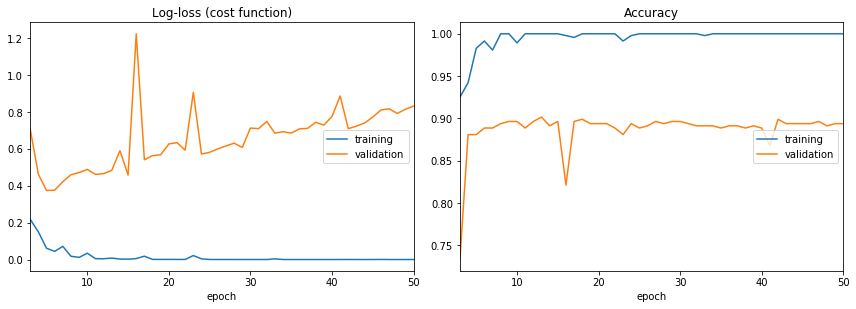

Log-loss (cost function):
training   (min:    0.000, max:    0.675, cur:    0.000)
validation (min:    0.374, max:    1.223, cur:    0.831)

Accuracy:
training   (min:    0.788, max:    1.000, cur:    1.000)
validation (min:    0.733, max:    0.902, cur:    0.894)


In [26]:
classify_train = full_model.fit(x_train, 
                                y_train, 
                                batch_size=batch_size,
                                epochs=epochs,
                                verbose=1,
                                validation_data=(x_val, y_val),
                                callbacks=[PlotLossesKeras()])

Definition of evaluation methods.

In [0]:
def get_train_val_performance(autoencoder_train):
  print('Loss (training set): ' + str(np.mean(autoencoder_train.history['loss'])))
  print('Validtion Loss (val set): ' + str(np.mean(autoencoder_train.history['val_loss'])))

In [0]:
# Model evaluation on test set
def evaluate_test_set(full_model):
    test_eval = full_model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', test_eval[0])
    print('Test accuracy:', test_eval[1])

In [0]:
# Predict labels
def predict_labels(full_model): 
    predicted_classes = full_model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    return predicted_classes

In [0]:
# Plot few predicted images and their class
def plot_predicted_images(predicted_images):
    for i, predicted_image in enumerate(predicted_images[:6]):
        plt.subplot(2, 3, i+1)
        plt.imshow(x_test[predicted_image], cmap='gray', interpolation='none')
        plt.title("Predicted {}, Class {}".format(predicted_classes[predicted_image], y_test_flat[predicted_image]))
        plt.tight_layout()

In [0]:
# Classification report
def get_classification_report(predicted_classes, y_test_flat):
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    print(classification_report(y_test_flat, predicted_classes, target_names=target_names))

#### Check the performance of the classifier with frozen encoder layers.

Loss value on training and validation sets (while training)

In [32]:
get_train_val_performance(classify_train)

Loss (training set): 0.03263135892064295
Validtion Loss (val set): 0.6475164365033814


Model Evaluation on the Test Set

In [33]:
evaluate_test_set(full_model)

Test loss: 0.8942137857312156
Test accuracy: 0.9072164948453608


Found 88 correct labels


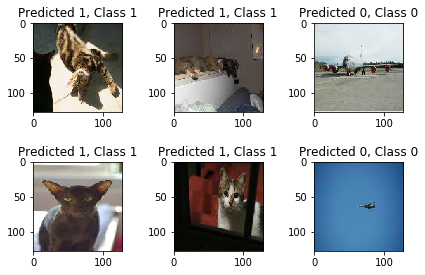

In [34]:
# For the first model (frozen autoencoder + connected NN)
y_test_flat = np.argmax(y_test,axis=1)
predicted_classes = predict_labels(full_model)
correct = np.where(predicted_classes==y_test_flat)[0]
incorrect = np.where(predicted_classes!=y_test_flat)[0]

print("Found %d correct labels"% len(correct))
plot_predicted_images(correct)

Found 9 incorrect labels


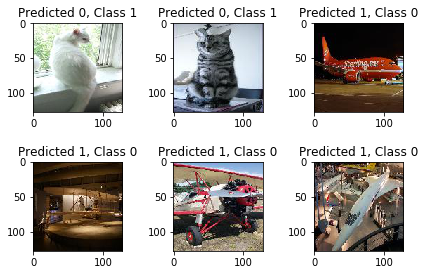

In [35]:
print("Found %d incorrect labels"% len(incorrect))
plot_predicted_images(incorrect)

#### Re-train the model once again, by making the encoder layers trainable, instead of freezing them.

In [0]:
for layer in full_model.layers[0:num_encoder_layers-1]:
    layer.trainable = True
    
full_model.compile(loss=LOSS, 
                   optimizer=OPTIMIZER,
                   metrics=['accuracy'])

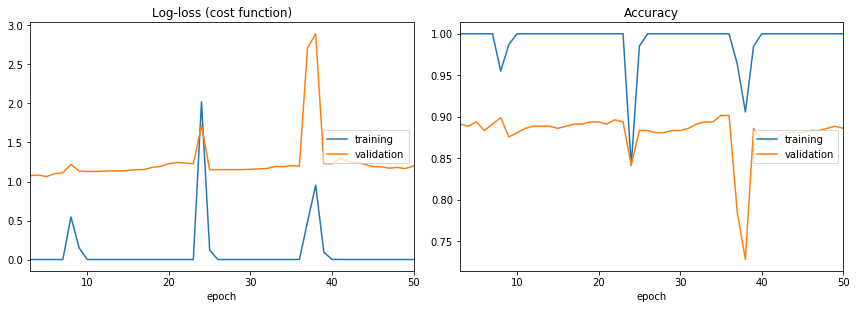

Log-loss (cost function):
training   (min:    0.000, max:    2.021, cur:    0.000)
validation (min:    1.064, max:    2.894, cur:    1.200)

Accuracy:
training   (min:    0.842, max:    1.000, cur:    1.000)
validation (min:    0.728, max:    0.902, cur:    0.886)


In [37]:
classify_train_retr = full_model.fit(x_train, 
                                    y_train, 
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(x_val, y_val),
                                    callbacks=[PlotLossesKeras()])

Next, the performance of the re-trained model is checked.

Loss value on training and validation sets (while training)

In [38]:
get_train_val_performance(classify_train_retr)

Loss (training set): 0.12221563425905765
Validtion Loss (val set): 1.2596522996062478


In [39]:
evaluate_test_set(full_model)

Test loss: 1.0248902322329574
Test accuracy: 0.9175257731958762


Found 89 correct labels


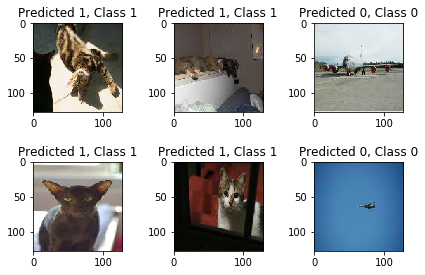

In [40]:
predicted_classes = predict_labels(full_model)
correct = np.where(predicted_classes==y_test_flat)[0]
incorrect = np.where(predicted_classes!=y_test_flat)[0]

print("Found %d correct labels"% len(correct))
plot_predicted_images(correct)

Found 8 incorrect labels


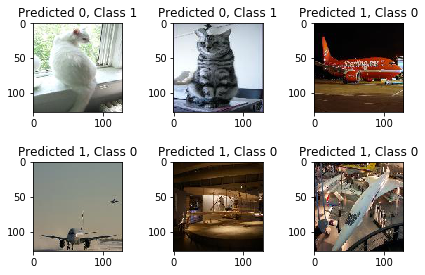

In [41]:
print("Found %d incorrect labels"% len(incorrect))
plot_predicted_images(incorrect)

Next, the model is trained with randomly initialized weights.


In [0]:
# full_model_2 - the 2nd model trained with randomly initialized weights
encoder_2 = Model(inputs=autoencoder.input, outputs=code_layer)
# Random weight init
for layer in encoder.layers:
  layer.trainable=True
  if hasattr(layer,'kernel_initializer'):
    layer.kernel_initializer = 'random_uniform'
    layer.bias_initializer = 'zeros'
            
full_model_2 = Model(encoder.input, fully_connected(encoder.output))


In [59]:
full_model_2.compile(loss=LOSS, 
                     optimizer=OPTIMIZER,
                     metrics=['accuracy'])
full_model_2.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 256)     7168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       295040    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 32, 64)        0         
__________

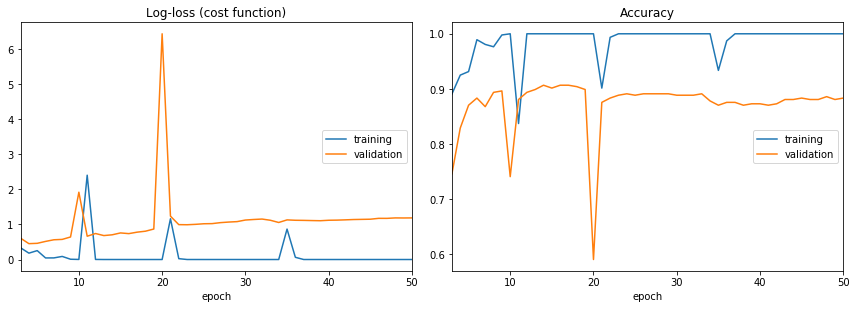

Log-loss (cost function):
training   (min:    0.000, max:    2.790, cur:    0.000)
validation (min:    0.452, max:    6.435, cur:    1.186)

Accuracy:
training   (min:    0.655, max:    1.000, cur:    1.000)
validation (min:    0.591, max:    0.907, cur:    0.883)


In [60]:
classify_train_2 = full_model_2.fit(x_train, 
                                    y_train, 
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(x_val, y_val),
                                    callbacks=[PlotLossesKeras()])

Loss value on training and validation sets (while training)

In [61]:
get_train_val_performance(classify_train_2)

Loss (training set): 0.17204413650711167
Validtion Loss (val set): 1.0637442111906226


In [62]:
evaluate_test_set(full_model_2)

Test loss: 1.1261753604822928
Test accuracy: 0.8762886597938144


Found 85 correct labels


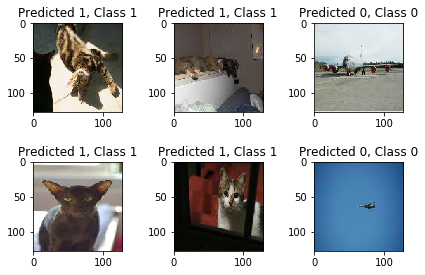

In [63]:
# For the second model
predicted_classes = predict_labels(full_model_2)
correct = np.where(predicted_classes==y_test_flat)[0]
incorrect = np.where(predicted_classes!=y_test_flat)[0]

print("Found %d correct labels"% len(correct))
plot_predicted_images(correct)

Found 12 incorrect labels


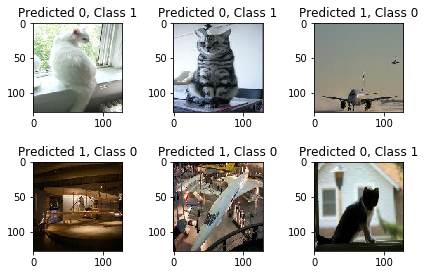

In [64]:
print("Found %d incorrect labels"% len(incorrect))
plot_predicted_images(incorrect)